In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv('/home/santhosh/Projects/courses/Pinnacle/.env')

True

In [3]:
import os 
import json

In [4]:
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import Image, display
from typing import List, Literal, Optional, TypedDict, Annotated

In [5]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

# Get News

In [6]:
from newsapi import NewsApiClient

In [7]:
NEWS_API_KEY = os.environ['NEWS_API_KEY']

In [8]:
news_api = NewsApiClient(api_key=NEWS_API_KEY)

In [9]:
@tool
def get_news(query: str, past_days: int, domains: str):
    """
    Get news based on the given parameters like query, past_days, etc.
    Args:
        query: search news about this topic
        past_days: For how many days in the past should we search?
        domains: search news in these resources
    """
    today = datetime.today()
    from_date = today - timedelta(days=past_days)
    news_details = news_api.get_everything(q=query, from_param=from_date, domains=domains,
                                           sort_by='relevancy')
    return news_details

In [10]:
gpt = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [11]:
gpt_with_tools = gpt.bind_tools([get_news])

# Score News

In [12]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage

In [13]:
def score_news(news_details: dict):
    """
    Calculate score for news_articles and sort them by the score.
        news_details: all the news articles    
    
    """
    # print(json.loads(news_details['messages'][-1].content)['news_details']['articles'][:])
    json_articles = json.loads(news_details['messages'][-1].content)['articles']
    if len(json_articles) > 15:
        articles = json_articles[:15]
    else:
        articles = json_articles
    # print(articles)
    system_prompt = """
    You are a news quality evaluator.
    I will provide you with a news article, with a title, description, and truncated content and other details. 
    Analyze and score the news article based on the following criteria:

    Clarity: How well the article conveys the message in a concise and understandable manner.
        Scale: 1 (unclear) to 25 (very clear)

    Credibility: Based on the description and other details provided, how likely is the article to be credible and factually accurate?
        Scale: 1 (not credible) to 25 (highly credible)

    Engagement potential: How likely the article is to capture the reader's attention or provoke further thought.
        Scale: 1 (not engaging) to 25 (very engaging)

    Impact: How significant or influential the article is in terms of its potential societal, technological, or political consequences.
        Scale: 1 (minimal impact) to 25 (high impact)

    Provide the total score out of 100 for the news article, adding the scores for each of the above criteria.

    You will be evaluating a lot news articles. So, score them such that we can sort all of them later.

    """
    prompt_template = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", "{news}")])

    class News(BaseModel):
        """News scoring system"""
    
        total_score: int = Field(description='total score for the news article')
        
        source: str = Field(description="The source of the news")
        author: Optional[str] = Field(default=None, description="The author to the news")
        
        title: str = Field(description="The title of the news")
        description: str = Field(description="The description to the news")
        
        url: str = Field(description="The url of the news")
        urlToImage: Optional[str] = Field(default=None, description="The image url of the news")

    gpt_4o = ChatOpenAI(model='gpt-4o', temperature=0)
    structured_gpt = gpt_4o.with_structured_output(News)
    chain = prompt_template | structured_gpt
    
    results = [chain.invoke({'news': article}).dict() for article in articles]

    df = pd.DataFrame(results).sort_values(by='total_score', ascending=False)
    
    return {"messages": [HumanMessage(content=df.to_dict(orient='records'))]}

# Send Email

In [14]:
import smtplib, ssl

In [15]:
import base64

In [16]:
import email

In [34]:
def send_email(sorted_news):

    articles = sorted_news['messages'][-1].content
    
    news_items_html = ""
    for article in articles[:10]:
        if article['urlToImage'] is not None:
            news_items_html += f"""
            <div class="news-item">
                <img src="{article['urlToImage']}" alt="{article['title']}">
                <div>
                    <h3><a href="{article['url']}">{article['title']}</a></h3>
                    <p>{article['description']}</p>
                </div>
            </div>
            """
        else:
            news_items_html += f"""
            <div class="news-item">
                <div>
                    <h3><a href="{article['url']}">{article['title']}</a></h3>
                    <p>{article['description']}</p>
                </div>
            </div>
            """

    html = f"""
        <html>
        <head>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    background-color: #c4c4c4;
                    margin: 0;
                    padding: 0;
                }}
                .container {{
                    width: 80%;
                    max-width: 600px;
                    margin: 0 auto;
                    background-color: #ffffff;
                    padding: 20px;
                    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
                }}
                h1 {{
                    text-align: center;
                    color: #333;
                }}
                .news-item {{
                    display: flex;
                    align-items: center;
                    justify-content: space-between;
                    border-bottom: 1px solid #eeeeee;
                    padding: 15px 0;
                }}
                .news-item h3 {{
                    margin: 0;
                    font-size: 16px;
                    color: #007BFF;
                    margin-left: 5px;
                }}
                .news-item p {{
                    font-size: 14px;
                    color: #666666;
                    margin: 5px 0;
                    margin-left: 5px;
                }}
                .news-item a {{
                    color: #007BFF;
                    text-decoration: none;
                }}
                .news-item img {{
                    width: 100px;
                    height: 100px;
                    object-fit: cover;
                    border-radius: 8px;
                }}
                .footer {{
                    margin-top: 20px;
                    text-align: center;
                    font-size: 12px;
                    color: #999999;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Curated News</h1>
                {news_items_html}
                <div class="footer">
                    <p>This is your personalized newsletter.</p>
                </div>
            </div>
        </body>
        </html>
    """
    
    port = 465  # For SSL

    sender_email = "santosh@analyticsvidhya.com"
    password = os.environ['GMAIL_PASSWORD']
    
    context = ssl.create_default_context()

    mail = email.message.EmailMessage()
    mail['To'] = "santosh@analyticsvidhya.com"
    mail['From'] = "santosh@analyticsvidhya.com"
    mail['Subject'] = "News Digest"
    mail.set_content(html, subtype='html')

    with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
        server.login(sender_email, password)
        server.send_message(mail)

# Agent

In [35]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

In [36]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = gpt_with_tools.invoke(messages)
    return {"messages": [response]}

In [37]:
def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [38]:
get_news_tool = ToolNode([get_news])

In [39]:
workflow = StateGraph(MessagesState)

workflow.add_node("LLM", call_model)

workflow.add_edge(START, "LLM")

workflow.add_node("tools", get_news_tool)

workflow.add_conditional_edges("LLM", call_tools)

workflow.add_node("score", score_news)

workflow.add_edge("tools", "score")

workflow.add_node("mail", send_email)

workflow.add_edge("score", "mail")

workflow.add_edge("mail", END)

In [40]:
agent = workflow.compile()

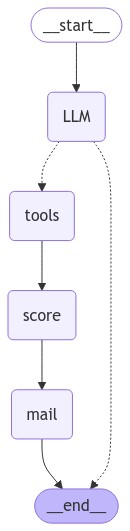

In [41]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [54]:
query = "what's the news on generative AI the past week?"

In [63]:
query = "What's the news on the Indian cricket team in the past month?"

In [61]:
inputs = {"messages": [("user", query)]}

In [62]:
async for chunk in agent.astream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What's the news on Indian cricket team in the past month?
================================== Ai Message ==================================
Tool Calls:
  get_news (call_zem5j5dqfoJkM76KrpsBMvlt)
 Call ID: call_zem5j5dqfoJkM76KrpsBMvlt
  Args:
    query: Indian cricket team
    past_days: 30
    domains: espncricinfo.com,cricbuzz.com,bbc.com,sports.ndtv.com
================================= Tool Message =================================
Name: get_news

{"status": "ok", "totalResults": 3, "articles": [{"source": {"id": null, "name": "BBC News"}, "author": "BBC Sport", "title": "West Indies legend Bravo retires from cricket", "description": "West Indies legend Dwayne Bravo, 40, brings forward his retirement after picking up a groin injury.", "url": "https://www.bbc.com/sport/cricket/articles/c9qv0q5qrv7o", "urlToImage": "https://ichef.bbci.co.uk/news/1024/branded_sport/935d/live/775787b0-7cb3-11ef-98ba-d370e3

In [56]:
async for chunk in agent.astream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the news on generative AI the past week?
================================== Ai Message ==================================
Tool Calls:
  get_news (call_AQg8lZzIaI2I9lf2AEd4Zdhf)
 Call ID: call_AQg8lZzIaI2I9lf2AEd4Zdhf
  Args:
    query: generative AI
    past_days: 7
    domains:
================================= Tool Message =================================
Name: get_news

{"status": "ok", "totalResults": 1276, "articles": [{"source": {"id": null, "name": "Yahoo Entertainment"}, "author": "Steve Dent", "title": "US senators urge regulators to probe potential AI antitrust violations", "description": "The US government has noticed the potentially negative effects of generative AI on areas like journalism and content creation. Senator Amy Klobuchar, along with seven Democrat colleagues, urged the Federal Trade Commission (FTC) and Justice Department to prob\u2026", "url": "https://consent.yahoo.com/v